In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

In [2]:
train_payment = pd.read_csv('./train_payment.csv')
train_activity = pd.read_csv('./train_activity.csv')
train_combat = pd.read_csv('./train_combat.csv')
train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')

## 1. 결제 패턴 변수 (군집=4, total과 상관: 29.35%)

In [91]:
import numpy as np
from pandas import DataFrame 

def payment_clt(train_payment, train_activity):
    # 실제 접속일  데이터
    real_day = train_activity[['acc_id','day','playtime']]
    real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

    # 전체 일자 데이터 (40000*28)
    day = np.zeros(shape=(40000*28,2))

    # acc_id 40000개 추출
    acc_id = train_activity[['acc_id','playtime']]
    acc_id = acc_id.groupby('acc_id').sum().reset_index()
    acc_id = acc_id['acc_id']
    acc_id = acc_id.values

    # day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
    for i in range(0,40000):
        for j in range(0,28):
            n = 28*i+j
            day[n][0] = acc_id[i]
            day[n][1] = j+1
    day_df = DataFrame(day, columns=['acc_id','day'])

    # 만든 데이터프레임에 실제 결제 데이터 merge
    pay_count_df = pd.merge(day_df, train_payment[['acc_id','day','amount_spent']],on=['acc_id','day'],how='outer').fillna(0)

    # 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
    pay_count_np = pay_count_df[['acc_id','amount_spent']].values

    # 열은 'acc_id + 28일' 이므로 29입니다.
    pattern_np = np.zeros(shape=(40000,29))
    for i in range(0,40000):
        for j in range(0,28):
            # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
            pattern_np[i][0] = pay_count_np[i*28][0]
            # 각 acc_id마다 행으로 28 단위로 입력된 결제량을 열 방향으로 입력합니다. 
            # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
            pattern_np[i][j+1] = pay_count_np[28*i+j][1]
        
    # 컬럼명 설정해서 df화
    pay_pattern = DataFrame(pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])

    # create model and prediction
    model = KMeans(n_clusters=4,algorithm='auto')

    model.fit(pay_pattern[pay_pattern.columns[1:]])

    predict = pd.DataFrame(model.predict(pay_pattern[pay_pattern.columns[1:]]))

    predict.columns=['pay_clt']

    r_pay = pd.concat([pay_pattern[pay_pattern.columns[1:]],predict],axis=1)

    acc = pay_pattern['acc_id']
    pay_clt = pd.concat([acc, r_pay['pay_clt']],axis=1)
    
    return pay_clt

## 2. 결제일수

In [78]:
def payment_count(train_payment, train_activity):
    pay_count = train_payment[['acc_id','day']].groupby('acc_id').count().reset_index()
    pay_count = pay_count.rename(columns={'day':'pay_count'})
    pay_count = pd.merge(pay_count,train_activity[['acc_id']].groupby('acc_id').count().reset_index(), on ='acc_id', how='outer').fillna(0)
    return pay_count

## 3. 일평균 결제량

In [79]:
def payment_mean(train_payment):
    pay_count = train_payment[['acc_id','day']].groupby('acc_id').count().reset_index()
    pay_sum = train_payment[['acc_id','amount_spent']].groupby('acc_id').sum().reset_index()
    pay_mean = pay_count[['acc_id']]
    pay_mean['pay_mean'] = pay_sum['amount_spent'] / pay_count['day']
    pay_mean = pay_mean.rename(columns={'amount_spent':'pay_mean'})

    pay_mean = pd.merge(pay_mean,train_activity[['acc_id']].groupby('acc_id').count().reset_index(), on ='acc_id', how='outer').fillna(0)
    return pay_mean

## 4. 28일 평균 결제량

In [6]:
def payment_mean_28(train_payment):
    pay_sum = train_payment[['acc_id','amount_spent']].groupby('acc_id').sum().reset_index()
    pay_mean_28 = pay_sum[['acc_id']]
    pay_mean_28['pay_mean_28'] = pay_sum['amount_spent'] / 28
    pay_mean_28 = pay_mean_28.rename(columns={'amount_spent':'pay_mean'})
    pay_mean_28 = pd.merge(pay_mean_28,train_activity[['acc_id']].groupby('acc_id').count().reset_index(), on ='acc_id', how='outer').fillna(0)
    return pay_mean_28

## 5. 결제일과 활동일의 간격

In [7]:
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id[['acc_id']].groupby('acc_id').sum().reset_index()
acc_id = acc_id.values

    # day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

In [56]:
def payment_non_login(train_activity, train_payment):
    # 실제 접속일  데이터
    real_day = train_activity[['acc_id','day','playtime']]
    real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

    # 전체 일자 데이터 (40000*28)
    day = np.zeros(shape=(40000*28,2))

    # acc_id 40000개 추출
    acc_id = train_activity[['acc_id','playtime']]
    acc_id = acc_id[['acc_id']].groupby('acc_id').sum().reset_index()
    acc_id = acc_id.values

    # day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
    for i in range(0,40000):
        for j in range(0,28):
            n = 28*i+j
            day[n][0] = acc_id[i]
            day[n][1] = j+1
    day_df = DataFrame(day, columns=['acc_id','day'])
    
    
    # 활동시간 합치기 위한 df
    act = train_activity[['acc_id', 'day','playtime','char_id']].groupby(['acc_id', 'day']).count().reset_index()

    # 40000*28 데이터에 일별 유저의 활동시간이랑 결제 금액 merge
    interval = pd.merge(day_df, act[['acc_id', 'day','playtime']], on =['acc_id', 'day'], how = 'outer')
    interval = pd.merge(interval, train_payment[['acc_id', 'day','amount_spent']], on =['acc_id', 'day'], how = 'outer').fillna(0)

    # 활동시간이 있으면 1, 아니면 0
    interval['act'] = np.where(interval['playtime']>0, 1, 0)
    # 결제 금액이 있으면 1, 아니면 0
    interval['pay'] = np.where(interval['amount_spent']>0, 1, 0)

    # login은 안했는데 결제를 한 날은 1, 아니면 0
    interval['non_login_pay'] = np.where((interval['act']==0) & (interval['pay']==1) , 1, 0)
    interval = interval.drop(['playtime','amount_spent', 'act', 'pay','day'], axis=1)
    pay_non_login = interval.groupby('acc_id').sum().reset_index()
    return pay_non_login

In [92]:
pay_clt = payment_clt(train_payment, train_activity)
pay_count = payment_count(train_payment, train_activity)
pay_mean =  payment_mean(train_payment)
pay_mean_28 = payment_mean_28(train_payment)

In [93]:
pay_mean_28.shape

(40000, 2)

In [94]:
data = pd.merge(pay_clt, pay_count, on ='acc_id')
data2 = pd.merge(data, pay_mean, on ='acc_id')
data3 = pd.merge(data2, pay_mean_28, on ='acc_id')
data4 = pd.merge(data3, pay_non_login, on ='acc_id')
data5 = pd.merge(data4, train_payment.groupby('acc_id').sum().reset_index(), on = 'acc_id', how='outer').fillna(0)

In [95]:
c = pd.merge(data5, train_label, on = 'acc_id').corr()
c

,acc_id,pay_clt,pay_count,pay_mean,pay_mean_28,non_login_pay,day,amount_spent_x,survival_time,amount_spent_y,secession,total_spent
acc_id,1.000000,0.003071,0.001448,0.004552,-0.000344,0.005786,0.000691,-0.000344,-0.001575,0.005493,0.002341,0.005891
pay_clt,0.003071,1.000000,-0.264270,-0.348673,-0.478408,0.003970,-0.252823,-0.478408,-0.076359,-0.031082,0.069592,-0.234420
pay_count,0.001448,-0.264270,1.000000,0.312452,0.722674,0.072587,0.942648,0.722674,0.112081,0.092106,-0.074268,0.447241
pay_mean,0.004552,-0.348673,0.312452,1.000000,0.718157,0.083921,0.293713,0.718157,0.059048,0.087233,-0.032662,0.334637
pay_mean_28,-0.000344,-0.478408,0.722674,0.718157,1.000000,0.076011,0.678096,1.000000,0.113073,0.092603,-0.079074,0.477582
non_login_pay,0.005786,0.003970,0.072587,0.083921,0.076011,1.000000,0.070979,0.076011,-0.082880,0.101588,0.072511,0.019476
day,0.000691,-0.252823,0.942648,0.293713,0.678096,0.070979,1.000000,0.678096,0.100052,0.090887,-0.060156,0.415595
amount_spent_x,-0.000344,-0.478408,0.722674,0.718157,1.000000,0.076011,0.678096,1.000000,0.113073,0.092603,-0.079074,0.477582
survival_time,-0.001575,-0.076359,0.112081,0.059048,0.113073,-0.082880,0.100052,0.113073,1.000000,-0.106241,-0.869090,0.279657
amount_spent_y,0.005493,-0.031082,0.092106,0.087233,0.092603,0.101588,0.090887,0.092603,-0.106241,1.000000,0.058308,0.266910


In [84]:
data5.shape

(40000, 8)

In [96]:
train = pd.merge(data5, train_label, on = 'acc_id')
total_spent = train[['acc_id','total_spent']]
amount_spent = train[['acc_id','amount_spent_y']]
survival_time = train[['acc_id','survival_time']]
secession = train[['acc_id','secession']]
train2 = train.drop(['total_spent', 'amount_spent_y', 'survival_time', 'secession','day'], axis=1)

In [46]:
secession = train[['acc_id','secession']]


In [20]:
train2.shape

(40000, 7)

In [170]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train2[train2.columns[1:]], total_spent['total_spent'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 6), (12000, 6), (28000,), (12000,))

In [171]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=700,random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

In [44]:
# 생존기간 정확도
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred))

RandomForestClassifier 0.5105


In [49]:
# 이탈 여부
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred), f1_score(y_test, y_pred))

RandomForestClassifier 0.5609166666666666 0.38739681432391576


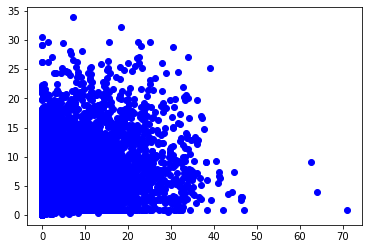

In [40]:
k = y_test.reset_index()
k['pred'] = y_pred
plt.plot(k['total_spent'],k['pred'],'bo')

In [173]:
from sklearn.metrics import mean_squared_error as mse
linreg_RMSE = np.sqrt(mse(k['pred'], k['total_spent']))
linreg_RMSE

6.1793651142453445

In [99]:
# 이탈 여부
print("특성 중요도 : \n{}".format(rnd_clf.feature_importances_))

특성 중요도 : 
[0.01543854 0.03694167 0.25992397 0.33328555 0.01744713 0.33696314]


In [41]:
# total spent 결과
print("특성 중요도 : \n{}".format(rnd_clf.feature_importances_))

특성 중요도 : 
[0.02524204 0.03955642 0.25681434 0.33213734 0.0170479  0.32920196]


In [45]:
# survival time 결과
print("특성 중요도 : \n{}".format(rnd_clf.feature_importances_))

특성 중요도 : 
[0.02453991 0.08213224 0.2986363  0.28622324 0.0241594  0.28430892]


In [50]:
# churn 결과
print("특성 중요도 : \n{}".format(rnd_clf.feature_importances_))

특성 중요도 : 
[0.02534641 0.05759954 0.30258525 0.29414423 0.02643125 0.29389333]


결론

- amount_spent보다 amount_spent / 28이 더 낫다

## 5. 결제 표준편차

- 너무 결제일수가 적은 사람들이 많아서 구하는 의미가 있는지 의문임

----------------------------------------

# 2 ROUND

## 1. 게임 머니 체인지 minus

In [57]:
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id[['acc_id']].groupby('acc_id').sum().reset_index()
acc_id = acc_id.values

    # day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

In [ ]:
# 만든 데이터프레임에 실제 결제 데이터 merge
pay_count_df = pd.merge(day_df, train_payment[['acc_id','day','amount_spent']],on=['acc_id','day'],how='outer').fillna(0)

    # 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
pay_count_np = pay_count_df[['acc_id','amount_spent']].values

    # 열은 'acc_id + 28일' 이므로 29입니다.
pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
            # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        pattern_np[i][0] = pay_count_np[i*28][0]
            # 각 acc_id마다 행으로 28 단위로 입력된 결제량을 열 방향으로 입력합니다. 
            # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        pattern_np[i][j+1] = pay_count_np[28*i+j][1]

In [154]:
train_activity['minus'] = np.where(train_activity['game_money_change']<0, 1, 0)
train_activity['plus'] = np.where(train_activity['game_money_change']>0, 1, 0)

In [182]:
# 활동시간 합치기 위한 df
act = train_activity[['acc_id', 'day','game_money_change','char_id','minus','plus','private_shop']].groupby(['acc_id', 'day']).sum().reset_index()

# 40000*28 데이터에 일별 유저의 활동시간이랑 결제 금액 merge
interval = pd.merge(day_df, act[['acc_id', 'day','game_money_change','minus','plus','private_shop']], on =['acc_id', 'day'], how = 'outer')
interval = pd.merge(interval, train_payment[['acc_id', 'day','amount_spent']], on =['acc_id', 'day'], how = 'outer').fillna(0)

# 활동시간이 있으면 1, 아니면 0
#interval['act'] = np.where(interval['playtime']>0, 1, 0)
# 결제 금액이 있으면 1, 아니면 0
#interval['pay'] = np.where(interval['amount_spent']>0, 1, 0)

# login은 안했는데 결제를 한 날은 1, 아니면 0
interval['minuss'] = np.where((interval['game_money_change']<0), 1, 0)
interval['pluss'] = np.where((interval['game_money_change']>0), 1, 0)
interval['minus_am'] = np.where((interval['game_money_change']<0), interval['game_money_change'], 0)
interval['plus_am'] = np.where((interval['game_money_change']>0), interval['game_money_change'], 0)
interval['diff_minus'] = np.where((interval['minus'] != interval['minuss']), 1, 0)
interval['diff_plus'] = np.where((interval['plus'] != interval['pluss']), 1, 0)

#interval = interval.drop(['playtime','amount_spent', 'act', 'pay','day'], axis=1)
#pay_non_login = interval.groupby('acc_id').sum().reset_index()

In [183]:
interval

,acc_id,day,game_money_change,minus,plus,private_shop,amount_spent,minuss,pluss,minus_am,plus_am,diff_minus,diff_plus
0,2.0,1.0,1.024810,0.0,1.0,2.462447,0.000000,0,1,0.000000,1.024810,0,0
1,2.0,2.0,-1.044201,1.0,0.0,3.149118,0.000000,1,0,-1.044201,0.000000,0,0
2,2.0,3.0,0.451317,0.0,1.0,3.183447,0.000000,0,1,0.000000,0.451317,0,0
3,2.0,4.0,-0.007230,1.0,0.0,3.131992,0.000000,1,0,-0.007230,0.000000,0,0
4,2.0,5.0,0.015398,0.0,1.0,3.135698,0.000000,0,1,0.000000,0.015398,0,0
5,2.0,6.0,-0.003800,1.0,0.0,3.134957,0.000000,1,0,-0.003800,0.000000,0,0
6,2.0,7.0,-0.364260,1.0,0.0,3.135230,0.000000,1,0,-0.364260,0.000000,0,0
7,2.0,8.0,-0.006619,1.0,0.0,2.544370,0.000000,1,0,-0.006619,0.000000,0,0
8,2.0,9.0,-0.010979,1.0,0.0,3.072071,0.000000,1,0,-0.010979,0.000000,0,0
9,2.0,10.0,-0.182742,1.0,0.0,3.145177,0.000000,1,0,-0.182742,0.000000,0,0


In [176]:
interval[(interval['acc_id']==54) & (interval['day']>=1) & (interval['day']<=28)]
#.sum()

,acc_id,day,game_money_change,minus,plus,private_shop,amount_spent,minuss,pluss,minus_am,plus_am
336,54.0,1.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
337,54.0,2.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
338,54.0,3.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
339,54.0,4.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
340,54.0,5.0,0.001380,0.0,1.0,0.0,0.0,0,1,0.000000,0.001380
341,54.0,6.0,-0.000134,1.0,0.0,0.0,0.0,1,0,-0.000134,0.000000
342,54.0,7.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
343,54.0,8.0,0.001908,0.0,1.0,0.0,0.0,0,1,0.000000,0.001908
344,54.0,9.0,0.000000,0.0,0.0,0.0,0.0,0,0,0.000000,0.000000
345,54.0,10.0,0.003900,0.0,1.0,0.0,0.0,0,1,0.000000,0.003900


In [184]:
testing = pd.merge(interval.groupby('acc_id').sum().reset_index(), train_label, on= 'acc_id')
cc= testing.corr()
cc

,acc_id,day,game_money_change,minus,plus,private_shop,amount_spent_x,minuss,pluss,minus_am,plus_am,diff_minus,diff_plus,survival_time,amount_spent_y,secession,total_spent
acc_id,1.000000,NaN,0.007071,0.003710,0.000052,-0.003703,-0.000344,-0.003192,-0.003339,0.006116,-0.004120,0.009088,0.002838,-0.001575,0.005493,0.002341,0.005891
day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
game_money_change,0.007071,NaN,1.000000,-0.019569,0.019252,-0.025377,0.006194,-0.061704,0.022096,0.198904,0.093948,0.003406,0.000274,-0.010849,-0.003646,0.009400,-0.023182
minus,0.003710,NaN,-0.019569,1.000000,0.512141,0.092974,0.101277,0.589323,0.115122,-0.199114,0.196482,0.729020,0.541466,0.262554,-0.037136,-0.212626,0.128817
plus,0.000052,NaN,0.019252,0.512141,1.000000,-0.062379,0.048193,-0.038621,0.685475,-0.176355,0.184854,0.603816,0.766148,0.158468,-0.046781,-0.106140,0.038433
private_shop,-0.003703,NaN,-0.025377,0.092974,-0.062379,1.000000,-0.186635,0.312794,-0.016622,-0.194822,0.190403,-0.109603,-0.084667,0.224877,-0.055109,-0.254192,-0.179271
amount_spent_x,-0.000344,NaN,0.006194,0.101277,0.048193,-0.186635,1.000000,0.085870,0.043330,-0.037896,0.040332,0.089838,0.057828,0.113073,0.092603,-0.079074,0.477582
minuss,-0.003192,NaN,-0.061704,0.589323,-0.038621,0.312794,0.085870,1.000000,-0.068557,-0.086521,0.069630,0.091395,0.013160,0.352513,-0.053937,-0.299129,0.123985
pluss,-0.003339,NaN,0.022096,0.115122,0.685475,-0.016622,0.043330,-0.068557,1.000000,-0.049451,0.056776,0.244167,0.270923,0.249240,-0.070201,-0.187127,0.043345
minus_am,0.006116,NaN,0.198904,-0.199114,-0.176355,-0.194822,-0.037896,-0.086521,-0.049451,1.000000,-0.956998,-0.102704,-0.086335,-0.105151,-0.000901,0.109008,-0.048444


In [135]:
train_label[(train_label['acc_id']==54)]['total_spent']

33280    2.952994
Name: total_spent, dtype: float64

In [133]:
acc_id[12]

array([54], dtype=int64)

In [ ]:
# 게임 머니 체인지에 -가 많은 경우
# 결제일에 아네나 플러스 높은 경우

---------

게임머니 관련 피처로 모델 돌려보기

In [1]:
# game_money_change	minus	plus	amount_spent_x	minuss	pluss	minus_am	plus_am	 순서의 컬럼으로 돌림
# 결과는 아래에 있음
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(testing[testing.columns[2:]].drop(['total_spent', 'amount_spent_y', 'survival_time', 'secession'], axis=1), total_spent['total_spent'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

NameError: name 'testing' is not defined

In [166]:
rnd_clf = RandomForestRegressor(n_estimators=700,random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

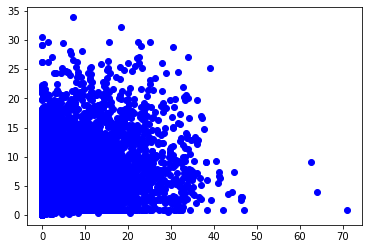

In [167]:
kk = y_test.reset_index()
kk['pred'] = y_pred
plt.plot(k['total_spent'],k['pred'],'bo')

In [168]:
print("특성 중요도 : \n{}".format(rnd_clf.feature_importances_))
# 마지막 2개는 acc별 minus와 plus

특성 중요도 : 
[0.13138779 0.07275903 0.06299837 0.36011012 0.05509884 0.05025026
 0.15574456 0.11165102]


In [169]:
from sklearn.metrics import mean_squared_error as mse
linreg_RMSE = np.sqrt(mse(kk['pred'], kk['total_spent']))
linreg_RMSE

5.704109827739102

------